In [1]:
import pandas as pd
import pickle
from sklearn.model_selection import train_test_split

from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import precision_score, recall_score, f1_score

import base
import os

2024-01-05 04:43:18.849441: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-05 04:43:18.887021: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-05 04:43:18.887061: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-05 04:43:18.888003: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-05 04:43:18.894348: I tensorflow/core/platform/cpu_feature_guar

In [2]:
SEED = 42
base.fix_seed(SEED)

desired_directory = '/home/jovyan/work/spectrum/'
os.chdir(desired_directory)

In [3]:
df_neg_data2x = pd.read_csv('Data/02_basedata/neg/neg2.csv')

In [4]:
import numpy as np
import pandas as pd
from sklearn.model_selection import LeaveOneOut
from sklearn.metrics import accuracy_score
import xgboost as xgb

## train/test/eval
columns_to_drop = ['Metabolitename', 'Ontology', 'dataset', 'AlignmentID', 'AverageMz']
X = df_neg_data2x.drop(columns=columns_to_drop).astype(float).values
y = df_neg_data2x['Ontology']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_eval, y_train, y_eval = train_test_split(X_train, y_train, test_size=0.2, random_state=42, stratify=y_train)
train_d, test_d = train_test_split(df_neg_data2x, test_size=0.2, random_state=42)

In [5]:
with open('Data/03_model/neg/neg_replacement_dict_all.pkl', 'rb') as file:
    replacement_dict = pickle.load(file)

In [6]:
# データの前処理：ラベルの置換
y_train_replaced0 = y_train.replace(replacement_dict).to_numpy().astype('int64')
y_test_replaced0 = y_test.replace(replacement_dict).to_numpy().astype('int64')
y_eval_replaced0 = y_eval.replace(replacement_dict).to_numpy().astype('int64')

ontlist = pd.DataFrame(y_train)['Ontology'].drop_duplicates().tolist()
from keras.utils import to_categorical
y_train_onehot = to_categorical(y_train_replaced0, len(ontlist))
y_test_onehot = to_categorical(y_test_replaced0, len(ontlist))
y_eval_onehot = to_categorical(y_eval_replaced0, len(ontlist))

In [7]:
from keras.models import load_model
model = load_model("Data/03_model/neg/neg_class_model_3")

In [8]:
y_pred_train = model.predict(X_train)
y_pred_train_max = np.argmax(y_pred_train, axis=1)
_, y_train_acc = np.where(y_train_onehot > 0) 

y_pred_test = model.predict(X_test)
y_pred_test_max = np.argmax(y_pred_test, axis=1)
_, y_test_acc = np.where(y_test_onehot > 0) 

# 正答率
train_accuracy = accuracy_score(y_train_acc, y_pred_train_max)
test_accuracy = accuracy_score(y_test_acc, y_pred_test_max)

print('Neural Network_train :', train_accuracy)
print('Neural Network_test :', test_accuracy)

52/52 [==============================] - 0s 9ms/step
Neural Network_train : 0.998468606431853
Neural Network_test : 0.9546846295162278


In [9]:

#SVM
svm_model = SVC(kernel='rbf', probability=True)
svm_model.fit(X_train, y_train_replaced0)
svm_y_pred = svm_model.predict(X_test)
svm_accuracy = accuracy_score(y_test_replaced0, svm_y_pred)
svm_precision = precision_score(y_test_replaced0, svm_y_pred, average='macro') 
svm_recall = recall_score(y_test_replaced0, svm_y_pred, average='macro')
svm_f1 = f1_score(y_test_replaced0, svm_y_pred, average='macro') 

# k近傍法
knn_model = KNeighborsClassifier()
knn_model.fit(X_train, y_train_replaced0)
knn_y_pred = knn_model.predict(X_test)
knn_accuracy = accuracy_score(y_test_replaced0, knn_y_pred)
knn_precision = precision_score(y_test_replaced0, knn_y_pred, average='macro') 
knn_recall = recall_score(y_test_replaced0, knn_y_pred, average='macro')
knn_f1 = f1_score(y_test_replaced0, knn_y_pred, average='macro') 

# Random Forest
rf_model = RandomForestClassifier()
rf_model.fit(X_train, y_train_replaced0)
rf_y_pred = rf_model.predict(X_test)
rf_accuracy = accuracy_score(y_test_replaced0, rf_y_pred)
rf_precision = precision_score(y_test_replaced0, rf_y_pred, average='macro') 
rf_recall = recall_score(y_test_replaced0, rf_y_pred, average='macro')
rf_f1 = f1_score(y_test_replaced0, rf_y_pred, average='macro') 

# XGBoost
xgb_model = OneVsRestClassifier(XGBClassifier())
xgb_model.fit(X_train, y_train_replaced0)
xgb_y_pred = xgb_model.predict(X_test)
xgb_accuracy = accuracy_score(y_test_replaced0, xgb_y_pred)
xgb_precision = precision_score(y_test_replaced0, xgb_y_pred, average='macro') 
xgb_recall = recall_score(y_test_replaced0, xgb_y_pred, average='macro')
xgb_f1 = f1_score(y_test_replaced0, xgb_y_pred, average='macro') 

##NN
y_pred_test = model.predict(X_test)
y_pred_test_max = np.argmax(y_pred_test, axis=1)
_, y_test_acc = np.where(y_test_onehot > 0) 

nn_accuracy = accuracy_score(y_test_acc, y_pred_test_max)
nn_precision = precision_score(y_test_acc, y_pred_test_max, average='macro')
nn_recall = recall_score(y_test_acc, y_pred_test_max, average='macro')
nn_f1 = f1_score(y_test_acc, y_pred_test_max, average='macro')


/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall

 1/52 [..............................] - ETA: 2s

/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


52/52 [==============================] - 1s 15ms/step


/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [10]:
print('SVM :', svm_accuracy, svm_precision, svm_recall, svm_f1)
print('KNN :', knn_accuracy, knn_precision, knn_recall, knn_f1)
print('Random Forest :', rf_accuracy, rf_precision, rf_recall, rf_f1)
print('XGBoost :', xgb_accuracy, xgb_precision, xgb_recall, xgb_f1)
print('Neural Network :', nn_accuracy, nn_precision, nn_recall, nn_f1)

SVM : 0.9191671769748928 0.6923063468430732 0.6106693070639007 0.6308608783336793
KNN : 0.8873239436619719 0.6324713140816276 0.5896069178914367 0.5864154785528255
Random Forest : 0.9479485609308022 0.7891471706859529 0.7326631945004294 0.7367124495355082
XGBoost : 0.9650949173300674 0.7812095153306075 0.7923130947674291 0.7779458533084083
Neural Network : 0.9546846295162278 0.7769563026905826 0.7733590357608033 0.7593507575717654


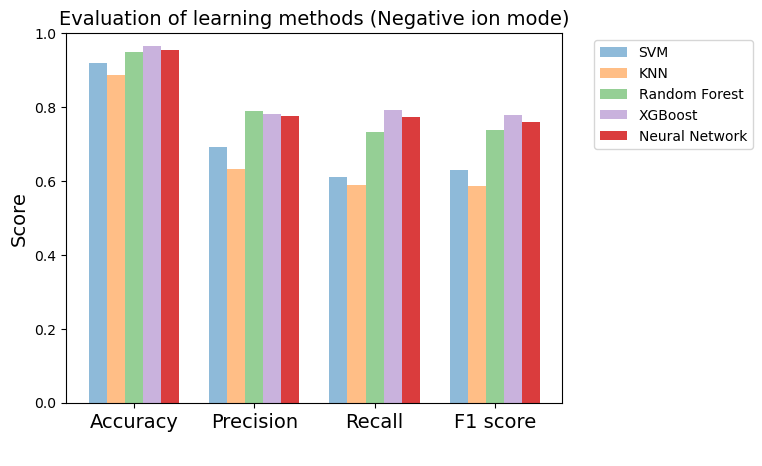

In [11]:
import matplotlib.pyplot as plt
import numpy as np

x_labels = ['Accuracy', 'Precision', 'Recall', 'F1 score']
x_datas = np.arange(len(x_labels))  # X軸の位置を設定

# 各評価パラメータの値をリストにまとめる
SVM = [svm_accuracy, svm_precision, svm_recall, svm_f1]
KNN = [knn_accuracy, knn_precision, knn_recall, knn_f1]
RF = [rf_accuracy, rf_precision, rf_recall, rf_f1]
XGB = [xgb_accuracy, xgb_precision, xgb_recall, xgb_f1]
NN = [nn_accuracy, nn_precision, nn_recall, nn_f1]

# 棒グラフを描画
bar_width = 0.15  # 棒の幅
index = np.arange(len(x_labels))  # X軸の位置

colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple']

plt.bar(index - 2 * bar_width, SVM, bar_width, label='SVM', align='center', color=colors[0], alpha=0.5)
plt.bar(index - bar_width, KNN, bar_width, label='KNN', align='center', color=colors[1], alpha=0.5)
plt.bar(index, RF, bar_width, label='Random Forest', align='center', color=colors[2], alpha=0.5)
plt.bar(index + bar_width, XGB, bar_width, label='XGBoost', align='center', color=colors[4], alpha=0.5)
plt.bar(index + 2 * bar_width, NN, bar_width, label='Neural Network', align='center', color=colors[3], alpha=0.9)
# X軸のラベルとタイトルを設定
plt.xlabel(' ', fontsize=14)
plt.ylabel('Score', fontsize=14)
plt.xticks(index, x_labels, fontsize=14)
plt.title('Evaluation of learning methods (Negative ion mode)', fontsize=14)

# 凡例を表示
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.ylim([0, 1])

plt.savefig('Data/svg/model/method/neg_method_f1score.svg', format='svg', dpi=300, bbox_inches='tight')
plt.show()